Augmented dataset shape: X=(3600, 10, 4), y=(3600,)

 Accuracy: 0.96

 Classification Report:
              precision    recall  f1-score   support

     bending       1.00      0.92      0.96        48
    clapping       0.93      0.90      0.91        48
    crawling       0.94      1.00      0.97        48
     falling       0.96      0.96      0.96        48
     jumping       0.96      1.00      0.98        48
       lying       0.92      0.94      0.93        48
     pulling       0.94      0.96      0.95        48
     pushing       0.96      0.96      0.96        48
     running       1.00      0.96      0.98        48
     sitting       1.00      0.94      0.97        48
   squatting       0.94      0.96      0.95        48
    standing       0.96      1.00      0.98        48
    twisting       0.94      1.00      0.97        48
     walking       0.98      0.92      0.95        48
      waving       0.94      0.96      0.95        48

    accuracy                           0

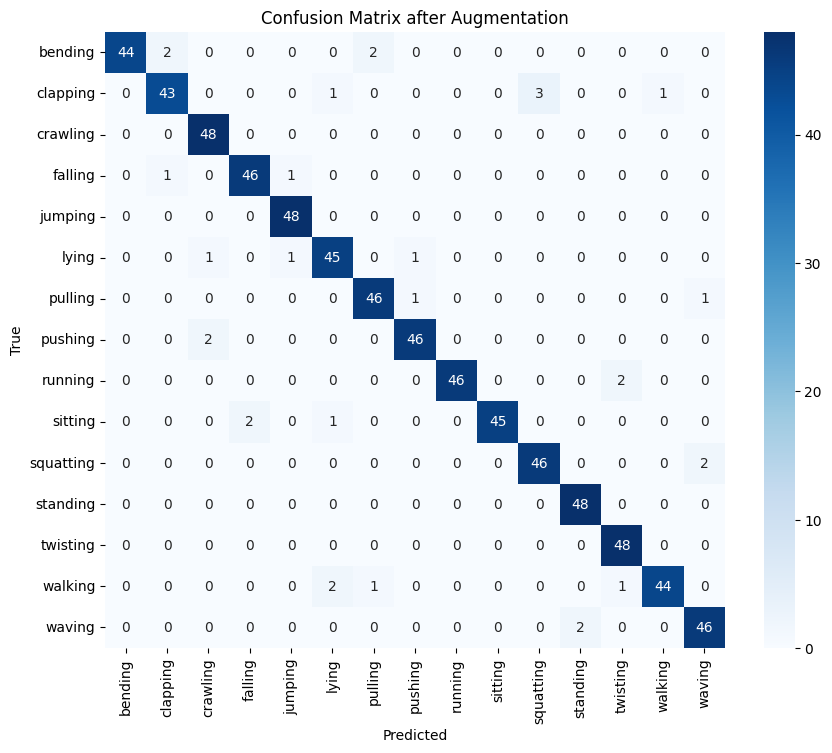

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1) Load your CSV (with sample_id, timestamp, amplitude_mean, amplitude_std, phase_mean, phase_std, label) ---
df = pd.read_csv('/content/wi-fi_csi_motion_dataset_refined.csv')

# --- 2) Build X_seq and y_labels arrays ---
groups = df.groupby('sample_id')
X_seq, y_labels = [], []
for _, g in groups:
    g = g.sort_values('timestamp')
    X_seq.append(g[['amplitude_mean','amplitude_std','phase_mean','phase_std']].values)
    y_labels.append(g['label'].iloc[0])
X_seq = np.array(X_seq)      # shape (300, 20, 4)
y_labels = np.array(y_labels)

# --- 3) Encode labels once ---
le = LabelEncoder()
y_enc = le.fit_transform(y_labels)  # ints 0–14

# --- 4) Augmentation: sliding windows + jittering ---
def sliding_windows(X, y, win_size=10, step=2):
    Xw, yw = [], []
    for seq, lbl in zip(X, y):
        for start in range(0, seq.shape[0] - win_size + 1, step):
            Xw.append(seq[start:start+win_size])
            yw.append(lbl)
    return np.array(Xw), np.array(yw)

def jitter(data, sigma=0.02):
    return data + np.random.normal(0, sigma, data.shape)

# create windows
X_win, y_win = sliding_windows(X_seq, y_enc, win_size=10, step=2)
# jitter each window once (double your data)
X_jit = jitter(X_win)
X_aug = np.vstack([X_win, X_jit])
y_aug = np.concatenate([y_win, y_win])

print(f"Augmented dataset shape: X={X_aug.shape}, y={y_aug.shape}")
# Expect roughly (300 * ((20-10)/2+1) * 2) ≈ (300*6*2)=3600 samples

# --- 5) Flatten windows for RandomForest ---
X_flat = X_aug.reshape(X_aug.shape[0], -1)  # (n_samples, 10*4=40 features)

# --- 6) Scale features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# --- 7) Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_aug, test_size=0.2, stratify=y_aug, random_state=42
)

# --- 8) Train a tuned Random Forest ---
clf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

# --- 9) Evaluate ---
y_pred = clf.predict(X_test)
print(f"\n Accuracy: {accuracy_score(y_test, y_pred):.2f}\n")
print(" Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# --- 10) Plot confusion matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix after Augmentation")
plt.show()






In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.5 MB/s eta 0:00:00


In [ ]:
joblib.dump(clf, 'rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')


['label_encoder.pkl']

In [ ]:
import gradio as gr
import numpy as np
import joblib

# Load model and tools
clf = joblib.load("rf_model.pkl")
scaler = joblib.load("scaler.pkl")
le = joblib.load("label_encoder.pkl")

# Predict function
def predict_position(amplitude_mean, amplitude_std, phase_mean, phase_std):
    input_seq = np.array([[amplitude_mean, amplitude_std, phase_mean, phase_std]] * 10).reshape(1, -1)
    input_scaled = scaler.transform(input_seq)
    pred = clf.predict(input_scaled)[0]
    label = le.inverse_transform([pred])[0]
    return f"🎯 Predicted Position: {label}"

# Interface
with gr.Blocks(css="""
body {
    background: linear-gradient(to right, #9b59b6, #8e44ad);
    font-family: 'Segoe UI', sans-serif;
}
#main {
    max-width: 720px;
    margin: 40px auto;
    padding: 30px;
    background: #ffffffee;
    border-radius: 20px;
    box-shadow: 0 10px 30px rgba(0,0,0,0.15);
}
#main_title {
    text-align: center;
    font-size: 3.8em;
    font-weight: 900;
    background: linear-gradient(90deg, #a855f7, #d8b4fe);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    filter: drop-shadow(0 0 6px #b06aed);
    margin-bottom: 30px;
    font-family: 'Segoe UI Black', 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
}

input[type=number] {
    background: #f5f0ff !important;
    border: 2px solid #b57edc !important;
    padding: 12px;
    border-radius: 12px;
    font-size: 1em;
}
textarea, input, .gr-box {
    box-shadow: 0 6px 14px rgba(155,89,182,0.1) !important;
}
#prediction {
    font-size: 1.4em;
    font-weight: bold;
    color: #4a0066;
    background-color: #f3e8ff;
    border: 2px solid #c084fc;
    padding: 16px;
    border-radius: 16px;
    text-align: center;
    box-shadow: 0 4px 12px rgba(155,89,182,0.25);
}
img {
    display: block;
    margin: 0 auto 20px auto;
    max-height: 120px;
    border-radius: 14px;
    border: 2px solid #d1b3ff;
}
button {
    background-color: #a855f7 !important;
    color: white !important;
    padding: 14px 30px;
    font-size: 1.1em;
    font-weight: bold;
    border-radius: 14px;
    margin-top: 10px;
    transition: background 0.3s ease;
}
button:hover {
    background-color: #9333ea !important;
}
""") as demo:

    with gr.Column(elem_id="main"):
        gr.Markdown(" **CSI Motion Classifier**", elem_id="main_title")

        gr.Image(value="/content/1043-signal-streams.gif", interactive=False)

        with gr.Row():
            amplitude_mean = gr.Number(label="📊 Amplitude Mean")
            amplitude_std = gr.Number(label="📉 Amplitude Std")

        with gr.Row():
            phase_mean = gr.Number(label="🌐 Phase Mean")
            phase_std = gr.Number(label="🔄 Phase Std")

        predict_btn = gr.Button("🚀 Predict")
        output = gr.Text(label="Result", elem_id="prediction")

        predict_btn.click(
            fn=predict_position,
            inputs=[amplitude_mean, amplitude_std, phase_mean, phase_std],
            outputs=output
        )

demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2a4810255d2f0c2974.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random

# --- 1) Load your CSV ---
df = pd.read_csv('/content/wi-fi_csi_motion_dataset_refined.csv')

# --- 2) Build sequences ---
groups = df.groupby('sample_id')
X_seq, y_labels = [], []
for _, g in groups:
    g = g.sort_values('timestamp')
    X_seq.append(g[['amplitude_mean','amplitude_std','phase_mean','phase_std']].values)
    y_labels.append(g['label'].iloc[0])
X_seq = np.array(X_seq)      # shape (300, 20, 4)
y_labels = np.array(y_labels)

# --- 3) Encode labels ---
le = LabelEncoder()
y_enc = le.fit_transform(y_labels)

# --- 4) Augmentation ---
def sliding_windows(X, y, win_size=10, step=2):
    Xw, yw = [], []
    for seq, lbl in zip(X, y):
        for start in range(0, seq.shape[0] - win_size + 1, step):
            Xw.append(seq[start:start+win_size])
            yw.append(lbl)
    return np.array(Xw), np.array(yw)

def jitter(data, sigma=0.02):
    return data + np.random.normal(0, sigma, data.shape)

X_win, y_win = sliding_windows(X_seq, y_enc, win_size=10, step=2)
X_jit = jitter(X_win)
X_aug = np.vstack([X_win, X_jit])
y_aug = np.concatenate([y_win, y_win])

print(f"Augmented dataset shape: X={X_aug.shape}, y={y_aug.shape}")

# --- 5) Flatten ---
X_flat = X_aug.reshape(X_aug.shape[0], -1)

# --- 6) Scaling ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# --- 7) Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_aug, test_size=0.2, stratify=y_aug, random_state=42
)

# --- 8) Model training ---
clf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

# --- 9) Evaluation ---
y_pred = clf.predict(X_test)
print(f"\n🔍 Accuracy: {accuracy_score(y_test, y_pred):.2f}\n")
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# --- 10) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix after Augmentation")
plt.show()

# --- 11) Test predictions on 2 new samples ---
print("\n🎯 Predicting on 2 random test samples:")
sample_indices = random.sample(range(len(X_test)), 2)

for idx in sample_indices:
    sample = X_test[idx].reshape(1, -1)
    true_label = le.inverse_transform([y_test[idx]])[0]
    predicted_label = le.inverse_transform(clf.predict(sample))[0]
    print(f"Sample {idx} ➤ True: {true_label}, Predicted: {predicted_label}")
